In [1]:
install.packages("ggplot2")
install.packages("dplyr")
install.packages("glmnet")


The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmphOj81C/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmphOj81C/downloaded_packages

The downloaded binary packages are in
	/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T//RtmphOj81C/downloaded_packages


In [21]:
library(dplyr)
library(glmnet)

# Import, format, scale data

In [22]:
#read in the data
data <- read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/fieldwork_regression_table.csv")
data$scaled_score <- (data$score_min -1)/4
data$logistic_transformed_score <-  1 / (1 + exp(-data$scaled_score))
trim_data <- data %>% select(-identifier,-score_min, - scaled_score,  -serviceable_agg, -score_ellen, -score_aadya, -serviceable_ellen, -serviceable_aadya)
scaled_data <- trim_data %>%
  mutate(across(-logistic_transformed_score, scale))

# Build a model

In [23]:
model <- lm(logistic_transformed_score ~ ., data = scaled_data)
fit_aic <- step(model)
summary(fit_aic)

Start:  AIC=-564.46
logistic_transformed_score ~ IT01V_packetsRecieved_ellen + IT01V_packetsRecieved_aadya + 
    IT01V_packetsLost_ellen + IT01V_packetsLost_aadya + IT01V_frameWidth_ellen + 
    IT01V_frameWidth_aadya + IT01V_frameHeight_ellen + IT01V_frameHeight_aadya + 
    IT01V_totalFreezesDuration_ellen + IT01V_totalFreezesDuration_aadya + 
    IT01V_framesPerSecond_ellen + IT01V_framesPerSecond_aadya + 
    IT01V_bytesReceived_in_bits_s_ellen + IT01V_bytesReceived_in_bits_s_aadya + 
    IT01V_totalProcessingDelay_ellen + IT01V_totalProcessingDelay_aadya + 
    IT01V_jitter_ellen + IT01V_jitter_aadya + IT01V_jitterBufferDelay_emissions_ellen + 
    IT01V_jitterBufferDelay_emissions_aadya + IT01A_bytesReceived_in_bits_s_ellen + 
    IT01A_bytesReceived_in_bits_s_aadya + IT01A_jitterBufferDelay_emissions_ellen + 
    IT01A_jitterBufferDelay_emissions_aadya + OT01V_packetsSent_s_ellen + 
    OT01V_packetsSent_s_aadya + OT01V_bytesSent_in_bits_s_ellen + 
    OT01V_bytesSent_in_bits_s


Call:
lm(formula = logistic_transformed_score ~ IT01V_packetsLost_aadya + 
    IT01V_framesPerSecond_ellen + IT01V_framesPerSecond_aadya + 
    IT01V_totalProcessingDelay_ellen + IT01V_totalProcessingDelay_aadya + 
    IT01V_jitterBufferDelay_emissions_ellen + IT01A_jitterBufferDelay_emissions_ellen + 
    IT01A_jitterBufferDelay_emissions_aadya + OT01V_packetsSent_s_ellen + 
    OT01V_bytesSent_in_bits_s_ellen + OT01V_framesPerSecond_ellen + 
    OT01V_framesPerSecond_aadya + OT01V_totalPacketSendDelay_ellen + 
    RIV_roundTripTime_aadya + RIV_fractionLost_ellen + RIA_fractionLost_aadya + 
    RIA_roundTripTime_aadya + AP_totalPlayoutDelay_ellen, data = scaled_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.07130 -0.01663  0.00031  0.01897  0.07109 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                              0.594679   0.003348 177.611  < 2e-16
IT01V_packetsLost_aadya                  0.0074

# scale data

In [9]:
scale_cols <- function(stage_data) {
    # Columns you want to conditionally exclude if they exist
    exclude_cols <- c("identifier", "Condition")
    # Only exclude columns that exist in the dataframe
    existing_exclude_cols <- intersect(exclude_cols, colnames(stage_data))
    # Remove only the columns that exist
    trim_data <- stage_data %>% select(-all_of(existing_exclude_cols))
    # Check if 'upload_x' is a column in the data
    if ("Upload_x" %in% colnames(stage_data)) {
        # Use the 'upload_x', 'download_x', 'latency_x' columns
        scaled_data <- trim_data %>%
            mutate(across(-c(Upload_x, Download_x, Latency_x, Upload_y, Download_y, Latency_y), 
                          ~ if (sd(.) != 0) scale(.) else .))
    } else {
        # Use the 'Upload', 'Download', 'Latency' columns
        scaled_data <- trim_data %>%
            mutate(across(-c(Upload, Download, Latency), 
                          ~ if (sd(.) != 0) scale(.) else .))
    }
    
    # Return the scaled data
    return(scaled_data)
}

# import and execute scaling

In [10]:
stage_1<- scale_cols(read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_1_regression_table.csv"))
stage_2 <- scale_cols(read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_2_regression_table.csv"))
stage_3 <- scale_cols(read.csv("/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/post_experiment/Regression_2_(web_to_serviceable)/regression_tables/stage_3_regression_table.csv"))
# Convert to matrix if needed
stage_1$RIV_fractionLost_ellen <- as.matrix(stage_1$RIV_fractionLost_ellen)


# infer values

In [11]:
stage_1$score <- predict(fit_aic, newdata = stage_1)
stage_2$score <- predict(fit_aic, newdata = stage_2)
stage_3$score <- predict(fit_aic, newdata = stage_3)

## model of inferred score to up/down/rtt

In [12]:
new_model1 <- lm(score ~ log(Upload) + log(Download) + log(Latency), data = stage_1)
new_model2 <- lm(score ~ log(Upload) + log(Download) + log(Latency), data = stage_2)
new_model3 <- lm(score ~ log(Upload_x) + log(Download_x) + log(Latency_x) + log(Upload_y) + log(Download_y) + log(Latency_y), data = stage_3)

In [14]:
summary(new_model1)
summary(new_model2)
summary(new_model3)

calculate_mse <- function(stage, model) {
    predictions <- predict(model, stage)
    mse <- mean((stage$score - predictions)^2)
    stage_name <- deparse(substitute(stage))
    return(paste(stage_name, mse, sep= " "))
}
calculate_mse(stage_1, new_model1)
calculate_mse(stage_2, new_model2)
calculate_mse(stage_3, new_model3)


Call:
lm(formula = score ~ log(Upload) + log(Download) + log(Latency), 
    data = stage_1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60846 -0.04071  0.00934  0.06748  0.28193 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.617877   0.092673   6.667 1.28e-10 ***
log(Upload)    0.022124   0.005026   4.402 1.50e-05 ***
log(Download) -0.024029   0.006316  -3.804 0.000173 ***
log(Latency)   0.004411   0.010211   0.432 0.666040    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1244 on 295 degrees of freedom
Multiple R-squared:  0.104,	Adjusted R-squared:  0.09491 
F-statistic: 11.42 on 3 and 295 DF,  p-value: 4.191e-07



Call:
lm(formula = score ~ log(Upload) + log(Download) + log(Latency), 
    data = stage_2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.27881 -0.02790  0.01420  0.07008  0.44600 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.398006   0.144599   2.752  0.00629 ** 
log(Upload)    0.041121   0.007911   5.198 3.83e-07 ***
log(Download) -0.021865   0.009901  -2.208  0.02801 *  
log(Latency)   0.012868   0.015926   0.808  0.41974    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1929 on 288 degrees of freedom
Multiple R-squared:  0.102,	Adjusted R-squared:  0.0926 
F-statistic:  10.9 on 3 and 288 DF,  p-value: 8.399e-07



Call:
lm(formula = score ~ log(Upload_x) + log(Download_x) + log(Latency_x) + 
    log(Upload_y) + log(Download_y) + log(Latency_y), data = stage_3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.71710 -0.02464  0.01990  0.05677  0.61002 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.6122351  0.1456836   4.202 3.53e-05 ***
log(Upload_x)    0.0004813  0.0055624   0.087   0.9311    
log(Download_x) -0.0060727  0.0069617  -0.872   0.3838    
log(Latency_x)   0.0065867  0.0115179   0.572   0.5679    
log(Upload_y)    0.0139198  0.0056030   2.484   0.0136 *  
log(Download_y) -0.0086943  0.0069955  -1.243   0.2149    
log(Latency_y)  -0.0055576  0.0114893  -0.484   0.6290    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1359 on 286 degrees of freedom
Multiple R-squared:  0.03278,	Adjusted R-squared:  0.01249 
F-statistic: 1.616 on 6 and 286 DF,  p-value: 0.1426


[1] "stage_1 0.0152611088879761"

[1] "stage_2 0.0366896771598741"

[1] "stage_3 0.0180230435604926"

# undo the logistic transform

In [15]:
transform_scores <- function(stage_data) {
  #ensure strictly between 0 and 1 to avoid undefined
  stage_data$score <- pmax(pmin(stage_data$score, 0.999), 0.001) 
  #apply logit transform to put back into normalised score form
  stage_data$real_score <-log(stage_data$score / (1 - stage_data$score))
  #then scale back up to 1-5
  stage_data$real_score_multiplied <- ((stage_data$real_score * 4) + 1)
  return(stage_data)
}
stage_1 <- transform_scores(stage_1)
stage_2 <- transform_scores(stage_2)
stage_3 <- transform_scores(stage_3)

# add a binary column that defines serviceability

In [16]:
create_binary_grouping <- function(stage_data) {
  stage_data$binary_col <- ifelse(stage_data$real_score_multiplied < 3, 0, 1)
  
  unserv_0 <- subset(stage_data, binary_col == 0)
  serv_1 <- subset(stage_data, binary_col == 1)
  
  unserv_0$group <- paste("UNSERV")
  serv_1$group <- paste("SERV")
  
  combined_data <- rbind(unserv_0, serv_1)
  return(combined_data)
}
#execute for each stage
combined_data1 <- create_binary_grouping(stage_1)
combined_data2 <- create_binary_grouping(stage_2)
combined_data3 <- create_binary_grouping(stage_3)

In [17]:
#show distribution of 0s and 1s
table(combined_data1$binary_col)
table(combined_data2$binary_col)
table(combined_data3$binary_col)


  0   1 
158 141 


  0   1 
111 181 


  0   1 
140 153 

# factors

In [18]:
create_factors <- function(data) {
    upload_levels <- c(500, 1000, 5000, 20000)
    latency_levels <-  c(100, 250, 400, 550, 750)
    download_levels <- c(2000, 5000, 12000, 25000, 50000)
    data$Upload_Factor <- factor(data$Upload, levels = upload_levels)
    data$Download_Factor <- factor(data$Download, levels = download_levels)
    data$Latency_Factor <- factor(data$Latency, levels = latency_levels)
  return(data)
}
combined_data1 <- create_factors(combined_data1)
combined_data2 <- create_factors(combined_data2)

create_factors3 <- function(data) {
    upload_levels <- c(500, 1000, 5000, 20000)
    latency_levels <-  c(100, 250, 400, 550, 750)
    download_levels <- c(2000, 5000, 12000, 25000, 50000)
    data$Upload_Factor_x <- factor(data$Upload_x, levels = upload_levels)
    data$Upload_Factor_y <- factor(data$Upload_y, levels = upload_levels)
    data$Latency_Factor_x <- factor(data$Latency_x, levels = latency_levels)
    data$Latency_Factor_y <- factor(data$Latency_y, levels = latency_levels)
    data$Download_Factor_x <- factor(data$Download_x, levels = download_levels)
    data$Download_Factor_y <- factor(data$Download_y, levels = download_levels)
  return(data)
}
combined_data3 <- create_factors3(combined_data3)


Warning message:
"The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
i Please use `after_stat(count)` instead."


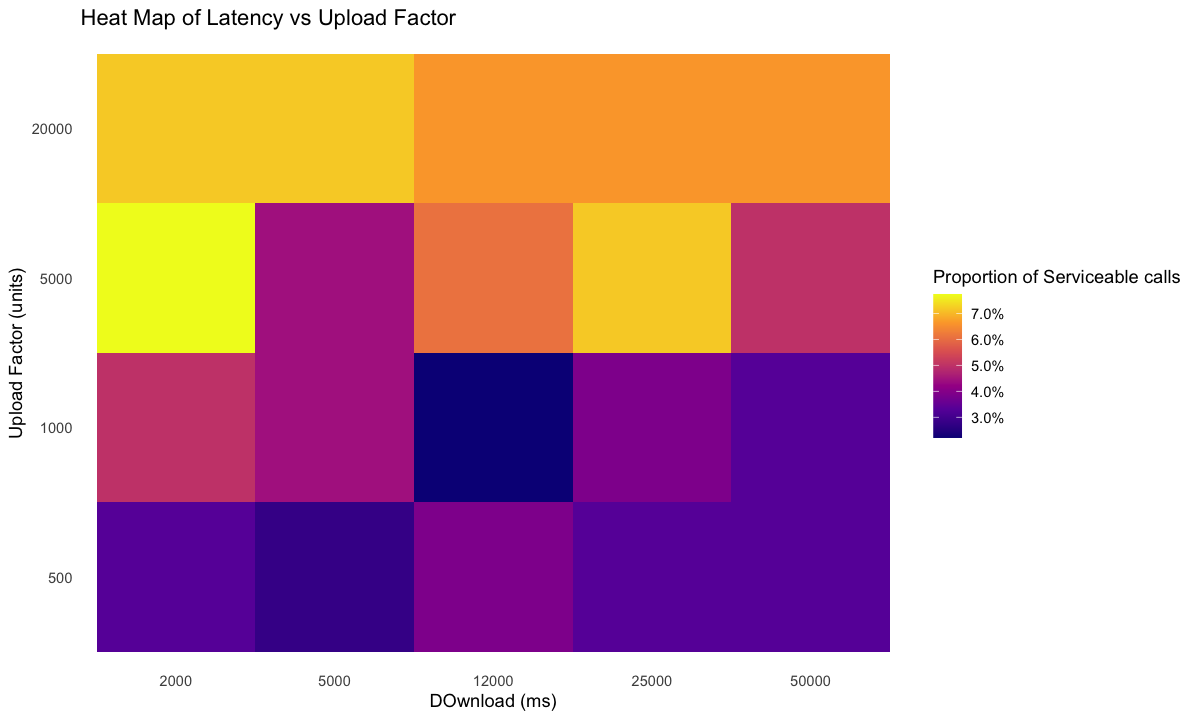

In [19]:
serv2 <-subset(combined_data2,binary_col == 1)
serv3 <- subset(combined_data3,binary_col == 1)
library(ggplot2)
total_points <- nrow(serv2)
options(repr.plot.width = 10, repr.plot.height = 6)
# Create a heat map with proportions
ggplot(data = serv2, aes(x = Download_Factor, y = Upload_Factor)) +
    stat_bin2d(bins = 30, aes(fill = ..count../total_points)) +  # Calculate proportion
    scale_fill_viridis_c(option = "plasma", labels = scales::percent) +  # Display as percentages
    labs(title = "Heat Map of Latency vs Upload Factor",
         x = "DOwnload (ms)",                       
         y = "Upload Factor (units)",              
         fill = "Proportion of Serviceable calls") +                    # Legend title showing proportion
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())


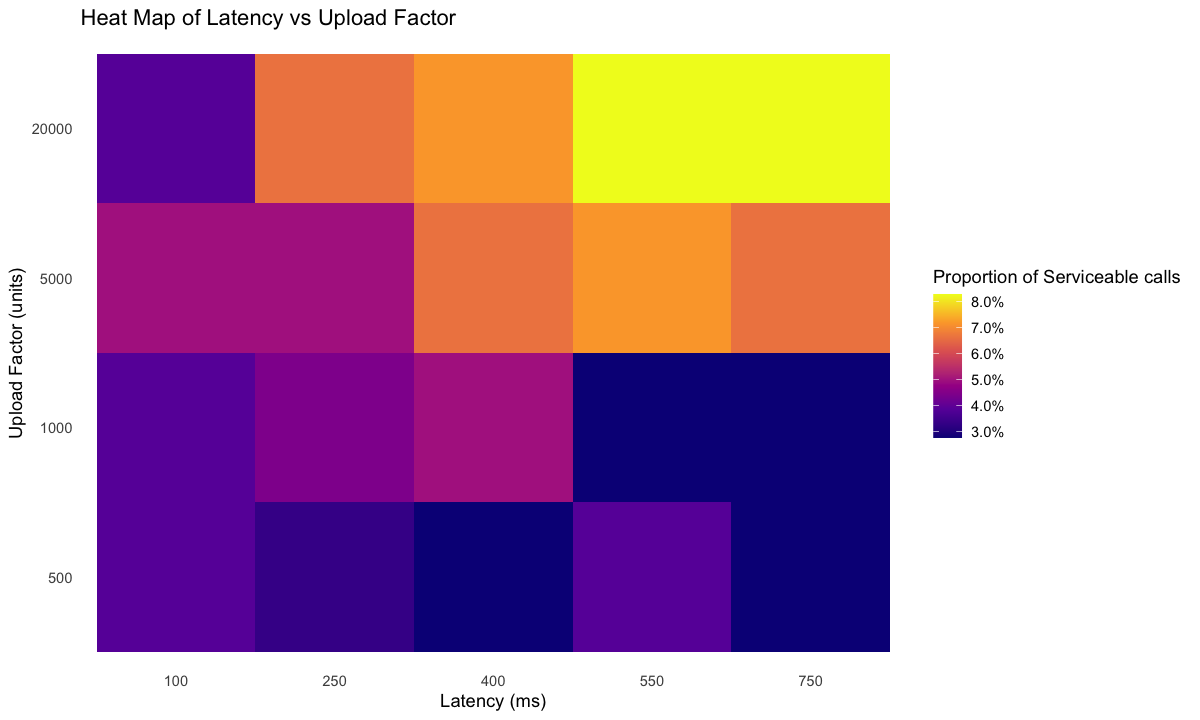

In [20]:
serv2 <-subset(combined_data2,binary_col == 1)
serv3 <- subset(combined_data3,binary_col == 1)
library(ggplot2)
total_points <- nrow(serv2)
options(repr.plot.width = 10, repr.plot.height = 6)
# Create a heat map with proportions
ggplot(data = serv2, aes(x = Latency_Factor, y = Upload_Factor)) +
    stat_bin2d(bins = 30, aes(fill = ..count../total_points)) +  # Calculate proportion
    scale_fill_viridis_c(option = "plasma", labels = scales::percent) +  # Display as percentages
    labs(title = "Heat Map of Latency vs Upload Factor",
         x = "Latency (ms)",                       
         y = "Upload Factor (units)",              
         fill = "Proportion of Serviceable calls") +                    # Legend title showing proportion
    theme_minimal() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())


# visualise Stages 1 and 2

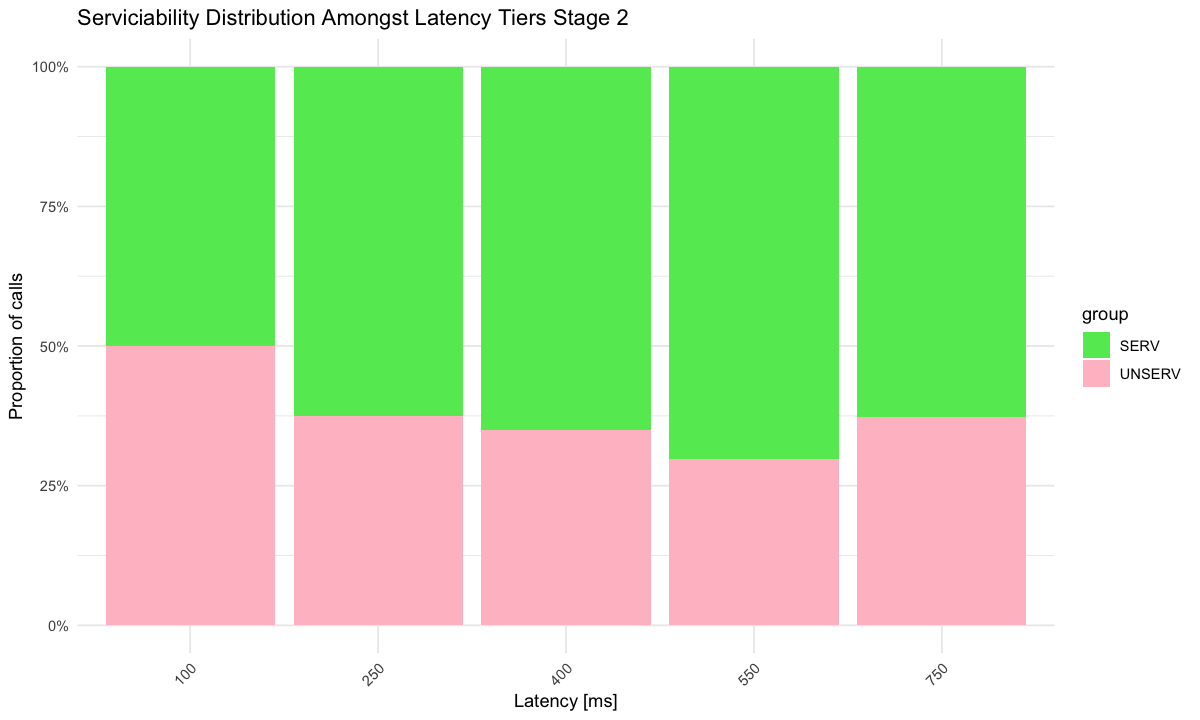

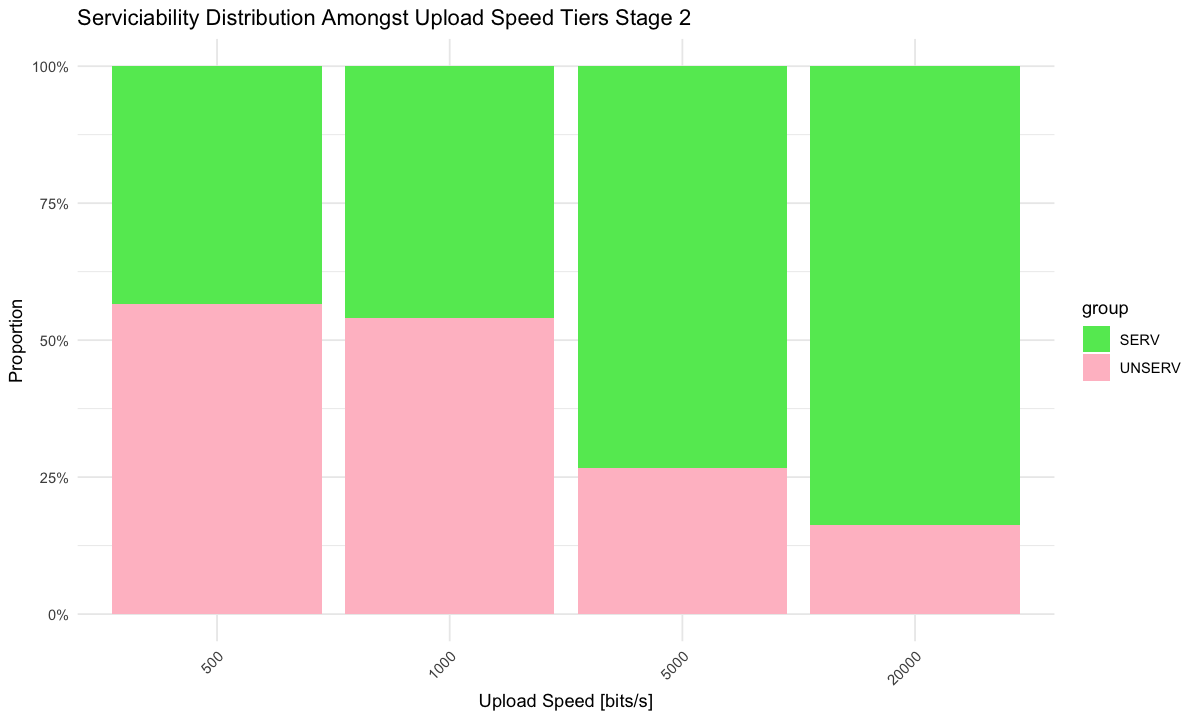

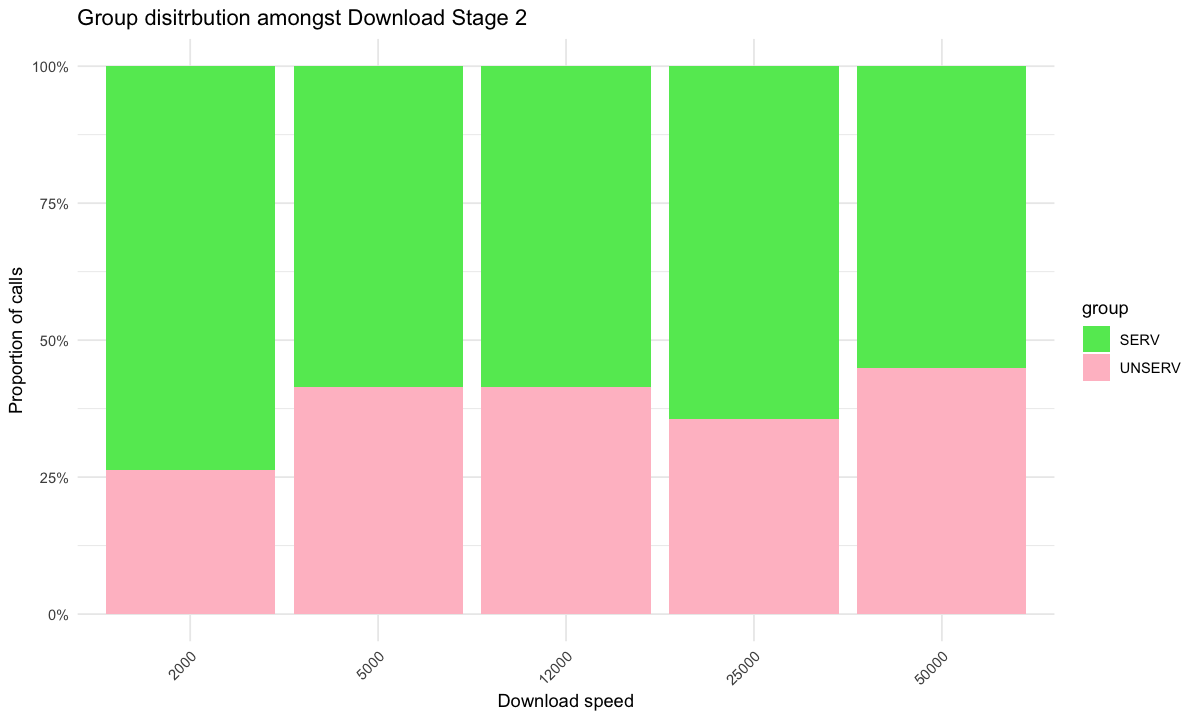

In [17]:
library(ggplot2)

plot_grouped_stacked_bars <- function(data, stage_name) {
  custom_colors <- c("UNSERV" = "pink", "SERV" = "#61e861")
  options(repr.plot.width = 10, repr.plot.height = 6)

  # Plot for Latency Factor
  p1 <- ggplot(data, aes(x = Latency_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviciability Distribution Amongst Latency Tiers", stage_name),
         x = "Latency [ms]",
         y = "Proportion of calls") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

  # Plot for Upload Factor
  p2 <- ggplot(data, aes(x = Upload_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviciability Distribution Amongst Upload Speed Tiers", stage_name),
         x = "Upload Speed [bits/s]",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  #download
  p3 <- ggplot(data, aes(x = Download_Factor, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Group disitrbution amongst Download", stage_name),
         x = "Download speed",
         y = "Proportion of calls") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

  return(list(latency_plot = p1, upload_plot = p2, download_plot =p3))
}

#make plots
plots_stage_1 <- plot_grouped_stacked_bars(combined_data1, "Stage 1")
plots_stage_2 <- plot_grouped_stacked_bars(combined_data2, "Stage 2")

#print plots
# print(plots_stage_1$latency_plot)
# print(plots_stage_1$upload_plot)

print(plots_stage_2$latency_plot)
print(plots_stage_2$upload_plot)
print(plots_stage_2$download_plot)

# Visualise Stage 3

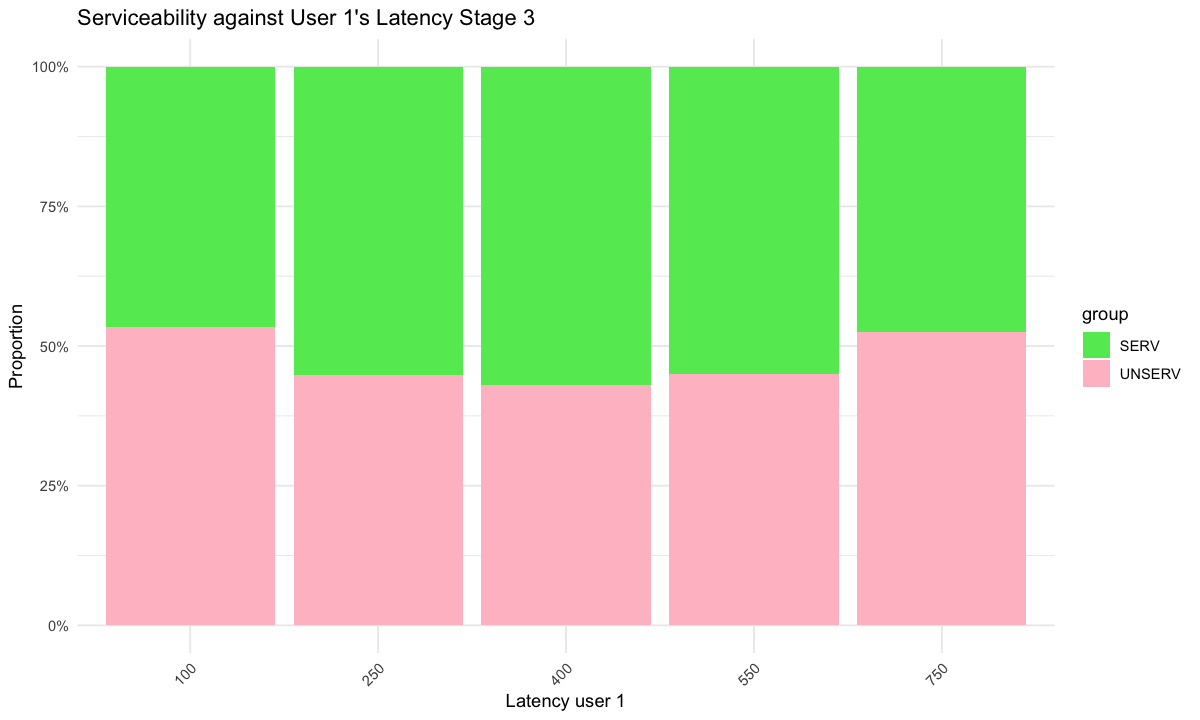

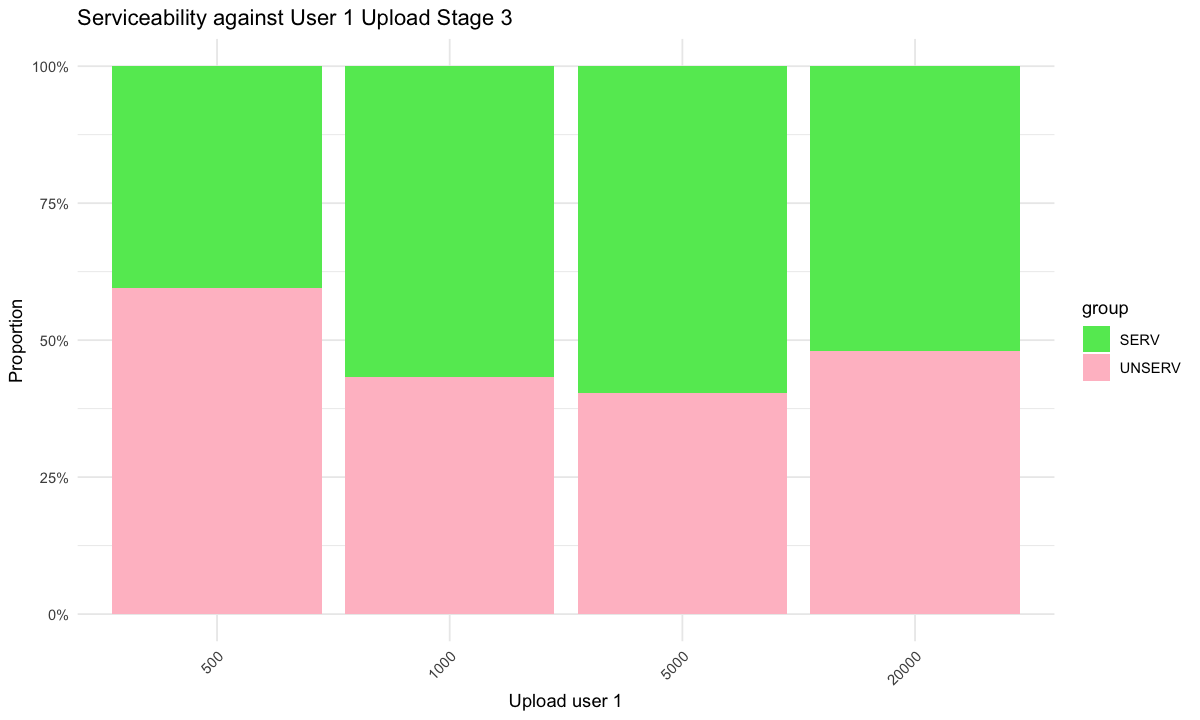

In [18]:
library(ggplot2)

plot_stage_3 <- function(data, stage_name) {
  custom_colors <- c("UNSERV" = "pink", "SERV" = "#61e861")
  options(repr.plot.width = 10, repr.plot.height = 6)

  # Plot for Latency Factor
  p1 <- ggplot(data, aes(x = Latency_Factor_x, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 1's Latency", stage_name),
         x = "Latency user 1",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

p2 <- ggplot(data, aes(x = Latency_Factor_y, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 2's Latency", stage_name),
         x = "Latency user 2",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +  # Format y-axis as percentage
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 


  # Plot for Upload Factor
  p3 <- ggplot(data, aes(x = Upload_Factor_x, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 1 Upload", stage_name),
         x = "Upload user 1",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  p4 <- ggplot(data, aes(x = Upload_Factor_y, fill = group)) +
    geom_bar(position = "fill") +  # Stacked bar with proportions
    labs(title = paste("Serviceability against User 2 Upload", stage_name),
         x = "Upload user 2",
         y = "Proportion") +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(values = custom_colors) + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  return(list(latency_plot_x = p1,latency_plot_y = p2, upload_plot_x = p3, upload_plot_y = p4))
}

#make plots
plots_stage_3 <- plot_stage_3(combined_data3, "Stage 3")
print(plots_stage_3$latency_plot_x)
#print(plots_stage_3$latency_plot_y)
print(plots_stage_3$upload_plot_x)
#print(plots_stage_3$upload_plot_y)